<a href="https://colab.research.google.com/github/evaalonsoortiz/dyn-rt-shim-sim/blob/main/dyn_rt_shim_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Realtime z-Shimming

This Colab notebook contains the simulation and analysis presented in xxx.




## Setup

To setup, we first clone the dyn_rt_shim_sim and spinalcordtoolbox repos and then instal the spinalcordtoolbox.

In [ ]:
 ! git clone https://github.com/evaalonsoortiz/dyn-rt-shim-sim

% cd dyn-rt-shim-sim
! pip install -r requirements.txt

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import plotly.graph_objects as go
import nibabel as nib
import sys
import os
import cv2
import re
import pandas as pd
import math
from os.path import join
from scipy.ndimage import gaussian_filter
from plotly.subplots import make_subplots

# Simulations

## Load Images

In [50]:
sc_mask = nib.load('sim_data/spinal_cord_seg.nii')
img = nib.load('sim_data/GRE-T1w.nii')

img_data = img.get_fdata()
sc_mask_data = sc_mask.get_fdata()
sc_mask_data[sc_mask_data < 1] = 0

## Define Relevant Constants

In [51]:
# -----------------------------------------------------------------------------#
# image acquistion parameters
# -----------------------------------------------------------------------------#
matrix = img.shape
image_res = img.header.get_zooms()

fov = np.array(image_res) * np.array(matrix)

TE = 15e-3 # [s]
TR = 1000e-3 # [s]

# -----------------------------------------------------------------------------#
# define k-space constants
# -----------------------------------------------------------------------------#
k_max = 1 / ( 2 * np.array(image_res) ) # maximum measured spatial frequencies in units of mm^-1
delta_k = 1 / fov # distance between points in k-space in units of mm^-1
[kx,ky] = np.meshgrid( np.linspace(start=-k_max[0],stop=k_max[0],num=matrix[0]) , np.linspace(start=-k_max[1],stop=k_max[1],num=matrix[1]), indexing='ij' )

# -----------------------------------------------------------------------------#
# define other constants related to the time-varying magnetic field
# -----------------------------------------------------------------------------#
w_r = 2 * math.pi / 3 # radial frequency of the respiratory motion in units of [rad/s]
RIROmax_uniform = 2 # maximum frequency offset caused by respiration (during inhalation) in units of [Hz]

# -----------------------------------------------------------------------------#
# define the spatial distribution for RIROmax
# -----------------------------------------------------------------------------#
[kx,ky] = np.meshgrid( np.linspace(start=-k_max[0],stop=k_max[0],num=matrix[0]) , np.linspace(start=-k_max[1],stop=k_max[1],num=matrix[1]), indexing='ij' )
[x,y] = np.meshgrid( np.linspace(start=-(matrix[0]-1)/2,stop=(matrix[0]-1)/2,num=matrix[0]) , np.linspace(start=-(matrix[1]-1)/2,stop=(matrix[1]-1)/2,num=matrix[1]), indexing='ij' ) # image grid (in [mm])

r = np.sqrt( (x*image_res[0])**2 + (y*image_res[1])**2 ) # radial position (in [mm])
r = abs( (r - np.max(np.max(r)) ) / np.max(np.max(r)) )
r = r**3
RIROmax = RIROmax_uniform*r

# -----------------------------------------------------------------------------#
# limit the RIROmax distribution to where you have signal in your image
# -----------------------------------------------------------------------------#

# Prepare noise mask
noise_mask = np.zeros(matrix)

# Pick four corners of 5x5
noise_mask[0:4,0:4] = 1
noise_mask[0:4,(-1-4):-1] = 1
noise_mask[(-1-4):-1,0:4] = 1
noise_mask[(-1-4):-1,(-1-4):-1] = 1

# apply mask to the data 
noise_data = np.multiply(img_data, noise_mask)

# Calculate background noise 
sigma = noise_data[noise_data!=0].std()

# create background mask
bkgrnd_mask = np.zeros(matrix)
bkgrnd_mask[img_data>(15*sigma)] = 1


RIROmax = np.multiply(bkgrnd_mask,RIROmax)
RIROmax = gaussian_filter(RIROmax, sigma=2)

simRIROmax_xz = RIROmax[128,:]
mean_simRIROmax = simRIROmax_xz[simRIROmax_xz!=0].mean()
std_simRIROmax = simRIROmax_xz[simRIROmax_xz!=0].std()
max_simRIROmax = simRIROmax_xz[simRIROmax_xz!=0].max()
min_simRIROmax = simRIROmax_xz[simRIROmax_xz!=0].min()

print('sim RIROmax range =',max_simRIROmax-min_simRIROmax)
print('sim RIROmax std =',std_simRIROmax)


sim RIROmax range = 1.9154825270871865
sim RIROmax std = 0.6771844932082189


## Simulate the reconstructed image in the presence of a time-varying magnetic field

In [52]:
# k-space data for the ideal image
FFT = np.fft.fftshift(np.fft.fft(np.fft.fftshift(img_data)))

# -----------------------------------------------------------------------------#
# For RIROmax(x,y)
# -----------------------------------------------------------------------------#
# modify the k-space data to take into account the effect of B(z,t)
exp = np.exp( (-2 * math.pi * 1j * TE) * RIROmax * np.sin(w_r * (TR * (matrix[1]/2 + np.divide(ky,delta_k[1]) ) + TE ) ) )
FFT_mod_RIROmax_xy = np.multiply( exp , FFT ) 

#recontruct the image
calcImage_RIROmax_xy = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(FFT_mod_RIROmax_xy)))

# -----------------------------------------------------------------------------#
# For RIROmax_uniform
# -----------------------------------------------------------------------------#
# modify the k-space data to take into account the effect of B(z,t)
exp = np.exp( (-2 * math.pi * 1j * TE) * RIROmax_uniform * np.sin(w_r * (TR * (matrix[1]/2 + np.divide(ky,delta_k[1]) ) + TE ) ) )
FFT_mod_RIROmax_uniform = np.multiply( exp , FFT ) 

#recontruct the image
calcImage_RIROmax_uniform = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(FFT_mod_RIROmax_uniform)))


## Simulate the reconstructed image in a realtime dynamic z-shimming experiment

In [53]:
# -----------------------------------------------------------------------------#
# For RIROmax(x,y)
# -----------------------------------------------------------------------------#
# calculate the average RIROmax in the spinal cord
RIROmax_meas = np.multiply(RIROmax,sc_mask_data)
RIROmax_meas = RIROmax_meas[np.nonzero(RIROmax_meas)].mean()

# modify the k-space data to take into account the effect of B(z,t) and z-shim gradients
diff = np.subtract(RIROmax * np.sin(w_r * (TR * (matrix[1]/2 + np.divide(ky,delta_k[1]) ) + TE ) ), RIROmax_meas * np.sin(w_r * (TR * (matrix[1]/2 + np.divide(ky,delta_k[1]) ) ) ))
exp = np.exp((2 * math.pi * 1j * TE) * diff)
zshim_FFT_mod_RIROmax_xy = np.multiply( exp , FFT ) 

#recontruct the image
zshim_calcImage_RIROmax_xy = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(zshim_FFT_mod_RIROmax_xy)))

# -----------------------------------------------------------------------------#
# For RIROmax_uniform
# -----------------------------------------------------------------------------#
# calculate the average RIROmax in the spinal cord
RIROmax_meas = np.multiply(RIROmax_uniform,sc_mask_data)
RIROmax_meas = RIROmax_meas[np.nonzero(RIROmax_meas)].mean()

# modify the k-space data to take into account the effect of B(z,t) and z-shim gradients
diff = np.subtract(RIROmax_uniform * np.sin(w_r * (TR * (matrix[1]/2 + np.divide(ky,delta_k[1]) ) + TE ) ), RIROmax_meas * np.sin(w_r * (TR * (matrix[1]/2 + np.divide(ky,delta_k[1]) ) ) ))
exp = np.exp((2 * math.pi * 1j * TE) * diff)
zshim_FFT_mod_RIROmax_uniform = np.multiply( exp , FFT )  

#recontruct the image
zshim_calcImage_RIROmax_uniform = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(zshim_FFT_mod_RIROmax_uniform)))

## Plot

[]

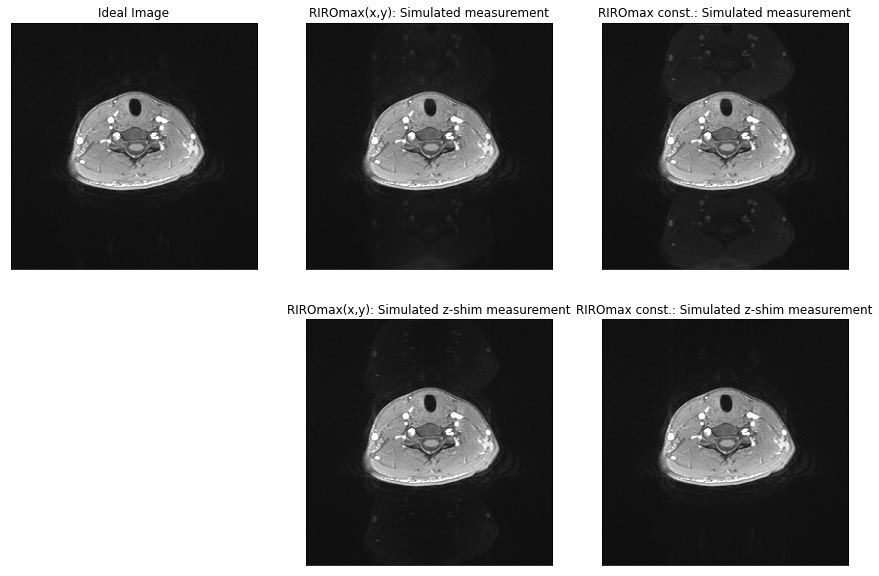

In [57]:
# display
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(2,3,1)
ax.imshow(np.rot90(img_data), cmap='gray', vmin=-100, vmax=1500)
ax.set_title('Ideal Image')
plt.setp(ax, xticks=[], yticks=[])

ax1 = fig.add_subplot(2,3,2)
ax1.imshow(np.rot90(np.abs(calcImage_RIROmax_xy)), cmap='gray', vmin=-100, vmax=1500)
ax1.set_title('RIROmax(x,y): Simulated measurement')
plt.setp(ax1, xticks=[], yticks=[])

ax2 = fig.add_subplot(2,3,3)
ax2.imshow(np.rot90(np.abs(calcImage_RIROmax_uniform)), cmap='gray', vmin=-100, vmax=1500)
ax2.set_title('RIROmax const.: Simulated measurement')
plt.setp(ax2, xticks=[], yticks=[])

ax3 = fig.add_subplot(2,3,5)
ax3.imshow(np.rot90(np.abs(zshim_calcImage_RIROmax_xy)), cmap='gray', vmin=-100, vmax=1500)
ax3.set_title('RIROmax(x,y): Simulated z-shim measurement')
plt.setp(ax3, xticks=[], yticks=[])

ax4 = fig.add_subplot(2,3,6)
ax4.imshow(np.rot90(np.abs(zshim_calcImage_RIROmax_uniform)), cmap='gray', vmin=-100, vmax=1500)
ax4.set_title('RIROmax const.: Simulated z-shim measurement')
plt.setp(ax4, xticks=[], yticks=[])

#Phantom Imaging

##Load Images

In [18]:
noShim = nib.load('phantom_data/GRE_REALTIME_ZSHIM_NOSHIM_0008_gre_realtime_zshim_NOSHIM_20210119133526_8.nii')
rtShim = nib.load('phantom_data/GRE_REALTIME_ZSHIM_RTSHIM_SIGMA2_0016_gre_realtime_zshim_rtSHIM_sigma2_20210119133526_16.nii')
mask = nib.load('phantom_data/GRE_REALTIME_ZSHIM_NOSHIM_0008_gre_realtime_zshim_NOSHIM_20210119133526_8_mask.nii.gz')

noShim_data = noShim.get_fdata()
rtShim_data = rtShim.get_fdata()
mask_data = mask.get_fdata()

## Compute PSG with and without shimming

In [22]:
T_mask = np.zeros_like(mask_data)
T_mask[mask_data == 2] = 1
mean_noShim_T = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))
mean_rtShim_T = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))

B_mask = np.zeros_like(mask_data)
B_mask[mask_data == 3] = 1
mean_noShim_B = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))
mean_rtShim_B = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))

S_mask = np.zeros_like(mask_data)
S_mask[mask_data == 1] = 1
mean_noShim_S = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))
mean_rtShim_S = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))

noShim_G = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))
rtShim_G = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))


for slice in range(noShim_data.shape[2]):
  for echo in range(noShim_data.shape[3]):

    noShim_data_Tmasked = np.multiply(T_mask[:,:,slice],noShim_data[:,:,slice,echo])
    mean_noShim_T[slice,echo] = noShim_data_Tmasked[noShim_data_Tmasked!=0].mean()

    noShim_data_Bmasked = np.multiply(B_mask[:,:,slice],noShim_data[:,:,slice,echo])
    mean_noShim_B[slice,echo] = noShim_data_Bmasked[noShim_data_Bmasked!=0].mean()

    noShim_data_Smasked = np.multiply(S_mask[:,:,slice],noShim_data[:,:,slice,echo])
    mean_noShim_S[slice,echo] = noShim_data_Smasked[noShim_data_Smasked!=0].mean()

    rtShim_data_Tmasked = np.multiply(T_mask[:,:,slice],rtShim_data[:,:,slice,echo])
    mean_rtShim_T[slice,echo] = rtShim_data_Tmasked[rtShim_data_Tmasked!=0].mean()

    rtShim_data_Bmasked = np.multiply(B_mask[:,:,slice],rtShim_data[:,:,slice,echo])
    mean_rtShim_B[slice,echo] = rtShim_data_Bmasked[rtShim_data_Bmasked!=0].mean()

    rtShim_data_Smasked = np.multiply(S_mask[:,:,slice],rtShim_data[:,:,slice,echo])
    mean_rtShim_S[slice,echo] = rtShim_data_Smasked[rtShim_data_Smasked!=0].mean()

    noShim_G[slice,echo] = 100*np.divide(np.add(mean_noShim_T[slice,echo],mean_noShim_B[slice,echo]),(2*mean_noShim_S[slice,echo]), where=mean_noShim_S[slice,echo]!=0)
    rtShim_G[slice,echo] = 100*np.divide(np.add(mean_rtShim_T[slice,echo],mean_rtShim_B[slice,echo]),(2*mean_rtShim_S[slice,echo]), where=mean_rtShim_S[slice,echo]!=0)


# Prepare noise mask
noise_mask = np.zeros(mask_data.shape)

# Pick four corners of 5x5
noise_mask[0:4,0:4,:] = 1
noise_mask[0:4,(-1-4):-1,:] = 1
noise_mask[(-1-4):-1,0:4,:] = 1
noise_mask[(-1-4):-1,(-1-4):-1,:] = 1

# apply mask to the data 
noise_data = np.zeros(noShim_data.shape)
for echo in range(noShim_data.shape[3]):
  noise_data[:,:,:,echo] = np.multiply(noShim_data[:,:,:,echo], noise_mask)

# Calculate SNR 
sigma = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))
SNR = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))

for slice in range(noShim_data.shape[2]):
  for echo in range(noShim_data.shape[3]):
    sigma[slice,echo] = noise_data[noise_data[:,:,slice,echo]!=0].std()
    SNR = np.divide(mean_noShim_S,sigma)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning:

divide by zero encountered in true_divide



## Plot

In [23]:
slice_num=['slice 1', 'slice 2', 'slice 3','slice 4','slice 5','slice 6','slice 7','slice 8','slice 9','slice 10','slice 11','slice 12','slice 13']

fig = make_subplots(rows=8, cols=1, shared_yaxes=True, subplot_titles=('TE1 = 2.5ms','TE2 = 5ms','TE3 = 8.5ms','TE4 = 11.5ms','TE4 = 14.5ms','TE6 = 17.5ms','TE7 = 20.5ms','TE8 = 23.5ms'))

fig.add_trace(go.Bar(name='no shimming', legendgroup="no shimming", x=slice_num, y=noShim_G[:,0],marker_color='blue',marker=dict(color=[4, 5, 6], coloraxis="coloraxis")),row=1, col=1)
fig.add_trace(go.Bar(name='realtime z-shimming', legendgroup="realtime z-shimming", x=slice_num, y=rtShim_G[:,0],marker_color='orange',marker=dict(color=[4, 5, 6], coloraxis="coloraxis")),row=1, col=1)

for echo in range(1, noShim_data.shape[3]):
  fig.add_trace(go.Bar(name='no shimming', legendgroup="no shimming", showlegend=False, x=slice_num, y=noShim_G[:,echo],marker_color='blue',marker=dict(color=[4, 5, 6], coloraxis="coloraxis")),row=(echo+1), col=1)
  fig.add_trace(go.Bar(name='realtime z-shimming', legendgroup="realtime z-shimming", showlegend=False, x=slice_num, y=rtShim_G[:,echo],marker_color='orange',marker=dict(color=[4, 5, 6], coloraxis="coloraxis")),row=(echo+1), col=1)

fig.update_layout(height=1200, width=1500)

# edit axis labels
fig['layout']['yaxis']['title']='PSG(%)'
fig['layout']['yaxis2']['title']='PSG(%)'
fig['layout']['yaxis3']['title']='PSG(%)'
fig['layout']['yaxis4']['title']='PSG(%)'
fig['layout']['yaxis5']['title']='PSG(%)'
fig['layout']['yaxis6']['title']='PSG(%)'
fig['layout']['yaxis7']['title']='PSG(%)'
fig['layout']['yaxis8']['title']='PSG(%)'

fig.update_layout(
    height=1200, width=1500,
    font=dict(
        size=15,
    )
)

for echo in range(noShim_data.shape[3]):
  for slice in range(noShim_data.shape[2]):
    fig.add_annotation(x=slice,y=np.maximum(noShim_G[slice,echo],rtShim_G[slice,echo]),text='SNR='+str(np.round_(SNR[slice,echo], decimals = 1)), showarrow=False,yshift=10,row=(echo+1), col=1)

fig.show()


# In-Vivo Imaging

## Load Images

In [27]:
noShim = nib.load('in_vivo_data/GRE_REALTIME_ZSHIM_NOSHIM_0004_gre_realtime_zshim_NOSHIM_20210127151556_4.nii')
rtShim = nib.load('in_vivo_data/GRE_REALTIME_ZSHIM_RTSHIM_0006_gre_realtime_zshim_rtSHIM_20210127151556_6.nii')
sc_mask = nib.load('in_vivo_data/sc_mask.nii.gz')
spinal_seg = nib.load('in_vivo_data/spinal_seg.nii')
bkgrnd_mask = nib.load('in_vivo_data/GRE_REALTIME_ZSHIM_NOSHIM_0004_gre_realtime_zshim_NOSHIM_20210127151556_4_mask.nii.gz')

noShim_data = noShim.get_fdata()
rtShim_data = rtShim.get_fdata()
sc_mask_data = sc_mask.get_fdata()
spinal_seg_data = spinal_seg.get_fdata()
bkgrnd_mask_data = bkgrnd_mask.get_fdata()

# Prepare noise mask
noise_mask = np.zeros(sc_mask_data.shape)

# Pick four corners of 5x5
noise_mask[0:4,0:4,:] = 1
#noise_mask[0:4,(-1-4):-1,:] = 1
noise_mask[(-1-4):-1,0:4,:] = 1
#noise_mask[(-1-4):-1,(-1-4):-1,:] = 1



## Compute PSG with and without shimming

In [28]:
mean_noShim_out = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))
mean_rtShim_out = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))

mean_noShim_sc_mask = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))
mean_noShim_sc_seg = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))
mean_rtShim_sc_mask = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))

noShim_G = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))
rtShim_G = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))

for slice in range(noShim_data.shape[2]):
  for echo in range(noShim_data.shape[3]):

    noShim_data_out_masked = np.multiply(bkgrnd_mask_data[:,:,slice],noShim_data[:,:,slice,echo])
    mean_noShim_out[slice,echo] = noShim_data_out_masked[noShim_data_out_masked!=0].mean()

    noShim_data_sc_masked = np.multiply(sc_mask_data[:,:,slice],noShim_data[:,:,slice,echo])
    mean_noShim_sc_mask[slice,echo] = noShim_data_sc_masked[noShim_data_sc_masked!=0].mean()

    noShim_data_sc_seg = np.multiply(spinal_seg_data[:,:,slice],noShim_data[:,:,slice,echo])
    mean_noShim_sc_seg[slice,echo] = noShim_data_sc_seg[noShim_data_sc_seg!=0].mean()    

    rtShim_data_out_masked = np.multiply(bkgrnd_mask_data[:,:,slice],rtShim_data[:,:,slice,echo])
    mean_rtShim_out[slice,echo] = rtShim_data_out_masked[rtShim_data_out_masked!=0].mean()

    rtShim_data_sc_masked = np.multiply(sc_mask_data[:,:,slice],rtShim_data[:,:,slice,echo])
    mean_rtShim_sc_mask[slice,echo] = rtShim_data_sc_masked[rtShim_data_sc_masked!=0].mean()

    noShim_G[slice,echo] = 100*np.divide(mean_noShim_out[slice,echo],(2*mean_noShim_sc_mask[slice,echo]), where=mean_noShim_sc_mask[slice,echo]!=0)
    rtShim_G[slice,echo] = 100*np.divide(mean_rtShim_out[slice,echo],(2*mean_rtShim_sc_mask[slice,echo]), where=mean_rtShim_sc_mask[slice,echo]!=0)


# Calculate SNR 
noise_data = np.zeros(noShim_data.shape)
for echo in range(noShim_data.shape[3]):
  noise_data[:,:,:,echo] = np.multiply(noShim_data[:,:,:,echo], noise_mask)


sigma = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))
SNR = np.zeros((noShim_data.shape[2],noShim_data.shape[3]))

for slice in range(noShim_data.shape[2]):
  for echo in range(noShim_data.shape[3]):
    sigma[slice,echo] = noise_data[noise_data[:,:,slice,echo]!=0].std()
    SNR = np.divide(mean_noShim_sc_seg,sigma)


# calculate the average PSG and SNR across slices
mean_noShim_G = np.zeros(noShim_data.shape[3])
std_noShim_G = np.zeros(noShim_data.shape[3])

mean_rtShim_G = np.zeros(rtShim_data.shape[3])
std_rtShim_G = np.zeros(rtShim_data.shape[3])

mean_SNR = np.zeros(noShim_data.shape[3])
std_SNR = np.zeros(noShim_data.shape[3])

for echo in range(noShim_data.shape[3]):
  mean_noShim_G[echo] = np.mean(noShim_G[:,echo])
  std_noShim_G[echo] = np.std(noShim_G[:,echo])
  
  mean_rtShim_G[echo] = np.mean(rtShim_G[:,echo])
  std_rtShim_G[echo] = np.std(rtShim_G[:,echo])
  
  mean_SNR[echo] = np.mean(SNR[:,echo])
  std_SNR[echo] = np.std(SNR[:,echo])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning:

divide by zero encountered in true_divide



##Plot

In [29]:
echo_num = ['TE1 = 2.5ms','TE2 = 5ms','TE3 = 8.5ms','TE4 = 11.5ms','TE4 = 14.5ms','TE6 = 17.5ms','TE7 = 20.5ms','TE8 = 23.5ms']

fig = go.Figure(data=[
    go.Bar(name='no shimming', x=echo_num, y=mean_noShim_G, error_y=dict(type='data', array=std_noShim_G), marker_color='blue',marker=dict(color=[4, 5, 6], coloraxis="coloraxis")),
    go.Bar(name='realtime z-shimming', x=echo_num, y=mean_rtShim_G, error_y=dict(type='data', array=std_rtShim_G), marker_color='orange',marker=dict(color=[4, 5, 6], coloraxis="coloraxis"))
])

fig.update_layout(
    barmode='group',
    yaxis_title="PSG(%)",
    font=dict(
        size=18,
    )
)

for echo in range(noShim_data.shape[3]):
  fig.add_annotation(x=echo_num[echo],y=np.maximum(mean_noShim_G[echo]+std_noShim_G[echo],mean_rtShim_G[echo]+std_rtShim_G[echo]),text='SNR='+str(np.round_(mean_SNR[echo], decimals = 1))+'('+str(np.round_(std_SNR[echo], decimals = 1))+')', showarrow=False,yshift=10)


fig.show()




# In-plane RIROmax variation

In [43]:
# -----------------------------------------------------------------------------#
# load simulation RIROmax data
# -----------------------------------------------------------------------------#

#RIROmax_img = nib.Nifti1Image(RIROmax, img.affine, img.header)
#nib.save(RIROmax_img, 'RIROmax_img.nii')

simRIROmax_xz = RIROmax[128,:]
mean_simRIROmax = simRIROmax_xz[simRIROmax_xz!=0].mean()
std_simRIROmax = simRIROmax_xz[simRIROmax_xz!=0].std()
max_simRIROmax = simRIROmax_xz[simRIROmax_xz!=0].max()
min_simRIROmax = simRIROmax_xz[simRIROmax_xz!=0].min()

print('sim RIROmax range =',max_simRIROmax-min_simRIROmax)
print('sim RIROmax std =',std_simRIROmax)

# -----------------------------------------------------------------------------#
# load phantom RIROmax data
# -----------------------------------------------------------------------------#
resampled_ph_riro = nib.load('phantom_data/resampled_riro.nii.gz')
resampled_ph_riro_data = resampled_ph_riro.get_fdata()

mean_ph_riro = np.zeros(resampled_ph_riro_data.shape[2])
std_ph_riro = np.zeros(resampled_ph_riro_data.shape[2])
max_ph_riro = np.zeros(resampled_ph_riro_data.shape[2])
min_ph_riro = np.zeros(resampled_ph_riro_data.shape[2])

for z in range(resampled_ph_riro_data.shape[2]):
  resampled_ph_riro_data_xz = resampled_ph_riro_data[55,:,z]
  mean_ph_riro[z] = resampled_ph_riro_data_xz[resampled_ph_riro_data_xz!=0].mean()
  std_ph_riro[z] = resampled_ph_riro_data_xz[resampled_ph_riro_data_xz!=0].std()
  max_ph_riro[z] = resampled_ph_riro_data_xz[resampled_ph_riro_data_xz!=0].max()
  min_ph_riro[z] = resampled_ph_riro_data_xz[resampled_ph_riro_data_xz!=0].min()

#print('phantom RIROmax range = ',(max_ph_riro-min_ph_riro))
#print('phantom RIROmax std = ',std_ph_riro)

#print('avg. phantom RIROmax range = ',(max_ph_riro-min_ph_riro).mean())
#print('avg. phantom RIROmax std = ',std_ph_riro.mean())


# -----------------------------------------------------------------------------#
# load in-vivo RIROmax data
# -----------------------------------------------------------------------------#
resampled_iv_riro = nib.load('in_vivo_data/resampled_riro.nii.gz')
resampled_iv_riro_data = resampled_iv_riro.get_fdata()

mean_iv_riro = np.zeros(resampled_iv_riro_data.shape[2])
std_iv_riro = np.zeros(resampled_iv_riro_data.shape[2])
max_iv_riro = np.zeros(resampled_iv_riro_data.shape[2])
min_iv_riro = np.zeros(resampled_iv_riro_data.shape[2])

for z in range(resampled_iv_riro_data.shape[2]):
  resampled_iv_riro_data_xz = resampled_iv_riro_data[64,:,z]
  mean_iv_riro[z] = resampled_iv_riro_data_xz[resampled_iv_riro_data_xz!=0].mean()
  std_iv_riro[z] = resampled_iv_riro_data_xz[resampled_iv_riro_data_xz!=0].std()
  max_iv_riro[z] = resampled_iv_riro_data_xz[resampled_iv_riro_data_xz!=0].max()
  min_iv_riro[z] = resampled_iv_riro_data_xz[resampled_iv_riro_data_xz!=0].min()

#print('in-vivo mean RIROmax range = ',(max_iv_riro-min_iv_riro).mean())
#print('in-vivo mean RIROmax std = ',std_iv_riro.mean())

mean_iv_sc_riro = np.zeros(resampled_iv_riro_data.shape[2])
std_iv_sc_riro = np.zeros(resampled_iv_riro_data.shape[2])
max_iv_sc_riro = np.zeros(resampled_iv_riro_data.shape[2])
min_iv_sc_riro = np.zeros(resampled_iv_riro_data.shape[2])

for z in range(resampled_iv_riro_data.shape[2]):
  resampled_iv_riro_data_xz = resampled_iv_riro_data[64,:,z]
  spinal_seg_data_xz = spinal_seg_data[64,:,z]

  mean_iv_sc_riro[z] = resampled_iv_riro_data_xz[spinal_seg_data_xz!=0].mean()
  std_iv_sc_riro[z] = resampled_iv_riro_data_xz[spinal_seg_data_xz!=0].std()
  max_iv_sc_riro[z] = resampled_iv_riro_data_xz[spinal_seg_data_xz!=0].max()
  min_iv_sc_riro[z] = resampled_iv_riro_data_xz[spinal_seg_data_xz!=0].min()

#print('in-vivo SC mean RIROmax range = ',(max_iv_sc_riro-min_iv_sc_riro).mean())
#print('in-vivo SC mean RIROmax std = ',std_iv_sc_riro.mean())

# plot
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=np.linspace(0,resampled_iv_riro_data.shape[2]), y=std_ph_riro, name='phantom',mode='lines+markers'))
fig.add_trace(go.Scatter(x=np.linspace(0,resampled_iv_riro_data.shape[2]), y=std_iv_riro, name='in-vivo',mode='lines+markers'))
fig.add_trace(go.Scatter(x=np.linspace(0,resampled_iv_riro_data.shape[2]), y=std_iv_sc_riro, name='in-vivo sc',mode='lines+markers'))
# Edit the layout
fig.update_layout(title = 'Standard Deviation of RIROmax in the AP Direction', xaxis_title='slice', yaxis_title='[Hz]')
fig.show()

# plot
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=np.linspace(0,resampled_iv_riro_data.shape[2]), y=mean_ph_riro, name='phantom',mode='lines+markers'))
fig.add_trace(go.Scatter(x=np.linspace(0,resampled_iv_riro_data.shape[2]), y=mean_iv_riro, name='in-vivo',mode='lines+markers'))
fig.add_trace(go.Scatter(x=np.linspace(0,resampled_iv_riro_data.shape[2]), y=mean_iv_sc_riro, name='in-vivo sc',mode='lines+markers'))
# Edit the layout
fig.update_layout(title = 'Mean RIROmax in the AP Direction', xaxis_title='slice', yaxis_title='[Hz]')
fig.show()

sim RIROmax range = 7.661930108348746
sim RIROmax std = 2.7087379728328758
